# Bayfield Jail

- API structure: https://developer.nrel.gov/api/reopt/stable/help?API_KEY=DEMO_KEY
- Models.py: https://github.com/NREL/REopt_API/blob/master/reoptjl/models.py

In [1]:
from math import nan
import numpy as np
import pandas as pd

from scipy.optimize import minimize, LinearConstraint

from reopt_interface import setup, create_post, run_reopt, parse_dispatch_series, \
    calc_retail_electric_cost, plotly_stacked, calc_monthly_peaks2, calc_mae2, build_price_vectors

# to silence warnigns
# InsecureRequestWarning: Unverified HTTPS request is being made to host 'developer.nrel.gov'. Adding certificate verification is strongly advised.
import urllib3
urllib3.disable_warnings()

pd.options.plotting.backend='plotly'

with open('api.key', 'r') as f:
    API_KEY = f.read()
    
cfg,tariff,load,forecasts = setup('bayfield_jail.yaml')

cfg.outdir

'outputs/bayfield_jail_v30_24.05.29-00.11/'

In [2]:
class dotdict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def costs_from_api_response(api_response):
    energy_cost =      api_response["outputs"]["ElectricTariff"]["year_one_energy_cost_before_tax"]
    demand_cost =      api_response["outputs"]["ElectricTariff"]["year_one_demand_cost_before_tax"]
    energy_revenue =   api_response["outputs"]["ElectricTariff"]["year_one_export_benefit_before_tax"]
    netcost =   energy_cost + demand_cost - energy_revenue
    
    costs = dotdict({'energy':energy_cost,
                     'demand':demand_cost,
                     'sellback':energy_revenue,
                     'total':netcost})
    
    return costs

def reopt_calc_retail_electric_cost(dispatch,cfg):
    dispatch = dispatch.copy()
    dispatch['load_and_batt_charge'] = dispatch['load'] - dispatch['batt'].clip(upper=0)
    dispatch['pv_and_batt_discharge'] = dispatch['pv'] + dispatch['batt'].clip(lower=0)

    post = create_post(cfg,
                    load_kw_series=dispatch['load_and_batt_charge'],
                    solar_cf_series=dispatch['pv_and_batt_discharge']/cfg.solar_capacity_kw,
                    batt_kw=0,
                    batt_h=0)

    api_response = run_reopt(post,api_key=API_KEY,print_results=True)
    
    return costs_from_api_response(api_response)

def calc_demand_charge2(dispatch:pd.DataFrame,tariff:dict,months:int) -> float:
    
    if isinstance(months,int):
        months = [months]

    demand_costs = []
    
    price_structure=[x[0]['rate'] for x in tariff['demandratestructure']]
    
    df = dispatch.copy()
    
    for month in months:        

        dfm = df[df.index.month==month]

        c_demand = 0
        for tou_level,demand_price in enumerate(price_structure):
        #tou_level=0
        #demand_price=price_structure[tou_level]

            tou_hours_weekday = [i for i,x in enumerate(tariff['demandweekdayschedule'][month-1]) if x == tou_level]
            tou_hours_weekend = [i for i,x in enumerate(tariff['demandweekendschedule'][month-1]) if x == tou_level]

            if len(tou_hours_weekday) == 0:
                weekday_demand = 0
            else:
                dfm_wd = dfm.loc[dfm.index.weekday.isin([0,1,2,3,4])]    
                weekday_demand = dfm_wd.loc[dfm_wd.index.hour.isin(tou_hours_weekday),'grid'].max()
            if len(tou_hours_weekend) == 0:
                weekend_demand = 0
            else:
                dfm_we = dfm.loc[dfm.index.weekday.isin([5,6])]
                weekend_demand = dfm_we.loc[dfm_we.index.hour.isin(tou_hours_weekend),'grid'].max()
            demand = max(weekday_demand,weekend_demand)

            #t_demand = dfm_wd.loc[dfm_wd.index.hour.isin(tou_hours_weekday),'grid'].idxmax()

            c_demand += round(demand * demand_price,2)
            
        demand_costs.append(c_demand)

    return(demand_costs)

# All data

In [3]:
load.plot()

Text(0.5, 0, 'Day of Week')

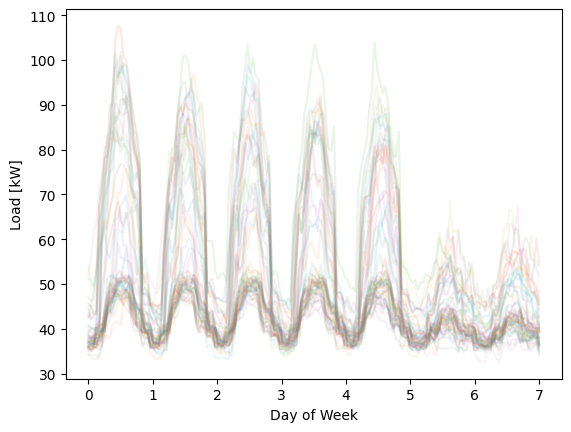

In [4]:
import matplotlib.pyplot as plt
t = np.linspace(0,7,168)[:168]
d = load['Load [kW]'].values[:(int(len(load)/168))*168]
d = list(d[-1*24:])+list(d[:-1*24])
d = np.array(d).reshape(-1,168)
plt.plot(t,d.T,alpha=0.1)
plt.ylabel('Load [kW]')
plt.xlabel('Day of Week')

# Make 2019 nem prices

In [5]:
nem_prices = pd.read_csv('data/tariff/PG&E NBT EEC Values 2024 Vintage.csv',
                         index_col=0,
                         parse_dates=True,
                         comment='#')
nem_prices['True Datetime'] = pd.to_datetime(nem_prices['True Datetime'])
nem_prices['weekday'] = nem_prices.index.weekday

nem_prices.index = nem_prices['True Datetime']
nem_prices = nem_prices.sort_index()
nem_prices['true weekday'] = nem_prices.index.weekday

# uncommment to save
#nem_prices[['Price']].to_csv('data/tariff/PG&E NBT EEC Values 2024 Vintage - fake 2019.csv')

# Create Forecasts

In [6]:
forecasts = load.copy(deep=True)#pd.read_csv('data/load/2019_JPL_v4.csv',index_col=0,parse_dates=True)

maxload = load[cfg.load_col].max()

forecasts['Perfect'] = forecasts[cfg.load_col]
print('Perfect',calc_mae2(forecasts['Perfect'],forecasts['Perfect'],normalize=True))


forecasts['Persist+'] = forecasts[cfg.load_persist_col] + forecasts[cfg.load_persist_col] * 0.21143711
print('Persist+',calc_mae2(forecasts['Perfect'],forecasts['Persist+'],normalize=True))
forecasts['Persist-'] = forecasts[cfg.load_persist_col] - forecasts[cfg.load_persist_col] * 0.22272292
print('Persist-',calc_mae2(forecasts['Perfect'],forecasts['Persist-'],normalize=True))

# nmae 5%

forecasts['ConstantDn'] = forecasts['Perfect'] - 0.1 * forecasts['Perfect'].max()
print('ConstantDn',calc_mae2(forecasts['Perfect'],forecasts['ConstantDn'],normalize=True))

forecasts['ConstantUp'] = forecasts['Perfect'] + 0.1 * forecasts['Perfect'].max()
print('ConstantUp',calc_mae2(forecasts['Perfect'],forecasts['ConstantUp'],normalize=True))


forecasts['ScaleLinDn'] = forecasts['Perfect'] - forecasts['Perfect'] * 0.2254007
forecasts['ScaleLinUp'] = forecasts['Perfect'] + forecasts['Perfect'] * 0.2254007
print('ScaleLinDn',calc_mae2(forecasts['Perfect'],forecasts['ScaleLinDn'],normalize=True))
print('ScaleLinUp',calc_mae2(forecasts['Perfect'],forecasts['ScaleLinUp'],normalize=True))

forecasts['ScaleQuadDn'] = forecasts['Perfect'] - forecasts['Perfect']**2 * 0.47107905/maxload
forecasts['ScaleQuadUp'] = forecasts['Perfect'] + forecasts['Perfect']**2 * 0.47107905/maxload
print('ScaleQuadDn',calc_mae2(forecasts['Perfect'],forecasts['ScaleQuadDn'],normalize=True))
print('ScaleQuadUp',calc_mae2(forecasts['Perfect'],forecasts['ScaleQuadUp'],normalize=True))

# tou_levels = np.array([tariff['energyweekdayschedule'][M-1][h] for M,h in zip(forecasts.index.month,forecasts.index.hour)])
# forecasts['TouScaleDn'] = forecasts.Perfect.values - maxload*0.0333 * tou_levels
# forecasts['TouScaleUp'] = forecasts.Perfect.values + maxload*0.0333 * tou_levels
# print('TouScaleDn',calc_mae2(forecasts['Perfect'],forecasts['TouScaleDn'],normalize=True))
# print('TouScaleUp',calc_mae2(forecasts['Perfect'],forecasts['TouScaleUp'],normalize=True))

energy_prices = build_price_vectors(load.index,tariff,cfg).energy.values
forecasts['EnergyPricesDn'] = forecasts['Perfect'] - energy_prices * (1.28408091 * maxload)
forecasts['EnergyPricesUp'] = forecasts['Perfect'] + energy_prices * (1.28408091 * maxload)
print('EnergyPricesDn',calc_mae2(forecasts['Perfect'],forecasts['EnergyPricesDn'],normalize=True))
print('EnergyPricesUp',calc_mae2(forecasts['Perfect'],forecasts['EnergyPricesUp'],normalize=True))

demand_prices = build_price_vectors(load.index,tariff,cfg).demand.values
forecasts['DemandPricesDn'] = forecasts['Perfect'] - demand_prices * (0.02796934 * maxload)
forecasts['DemandPricesUp'] = forecasts['Perfect'] + demand_prices * (0.02796934 * maxload)
print('DemandPricesDn',calc_mae2(forecasts['Perfect'],forecasts['DemandPricesDn'],normalize=True))
print('DemandPricesUp',calc_mae2(forecasts['Perfect'],forecasts['DemandPricesUp'],normalize=True))

std=forecasts['Perfect'].std()
forecasts['Random'] = forecasts['Perfect'] + (13.47912488)*np.random.normal(0,1,len(forecasts))
print('Random',calc_mae2(forecasts['Perfect'],forecasts['Random'],normalize=True))

for col in forecasts.columns:
    forecasts[col] = forecasts[col].clip(lower=0)


forecasts = forecasts.drop([cfg.load_col,cfg.load_persist_col],axis=1)

#forecast.to_csv('data/load/2019_JPL_v4_fake_forecast.csv')
forecasts.to_csv('data/load/Jail_load_solar_1min_2021-4-21_2022-4-19_profilized_fake_forecast.csv')

#forecasts = forecasts.columns

Perfect 0.0
Persist+ 0.10001879749670405
Persist- 0.10013992682518286
ConstantDn 0.1
ConstantUp 0.1
ScaleLinDn 0.1000231186559557
ScaleLinUp 0.10002311865595573
ScaleQuadDn 0.10003049806316532
ScaleQuadUp 0.10003049806316532
EnergyPricesDn 0.0999999996349315
EnergyPricesUp 0.0999999996349315
DemandPricesDn 0.09999996904109588
DemandPricesUp 0.0999999690410959
Random 0.0996218024414419


### Choose coefficients

In [7]:
maxload = load[cfg.load_col].max()

target_nmae = 0.10#*maxload

d = load[cfg.load_col].values/maxload
p = load['Load Persist 7d [kW]'].values/maxload
r = np.random.normal(0,1,len(forecasts))/maxload
def forecast(x):
    #return d + x[0]
    #return d + d * x[0]
    #return d + d**2 * x[0]
    #return d + x[0]*tou_levels
    #return d + x[0]*energy_prices
    #return d + x[0]*demand_prices
    #return d+r*x[0]
    return p + p*x[0]

def obj(x):
    return (np.mean(np.abs(d-forecast(x))) - target_nmae)**2

linear_constraint = LinearConstraint([[1]], [0], [100])

r = minimize(obj,np.array([1.1]),options={'disp':True},constraints=[linear_constraint])

print('Optimal values of x:',r.x)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.532748854629821e-10
            Iterations: 4
            Function evaluations: 9
            Gradient evaluations: 4
Optimal values of x: [0.21143711]


In [8]:
forecasts.columns

Index(['Perfect', 'Persist+', 'Persist-', 'ConstantDn', 'ConstantUp',
       'ScaleLinDn', 'ScaleLinUp', 'ScaleQuadDn', 'ScaleQuadUp',
       'EnergyPricesDn', 'EnergyPricesUp', 'DemandPricesDn', 'DemandPricesUp',
       'Random'],
      dtype='object')

Persist+


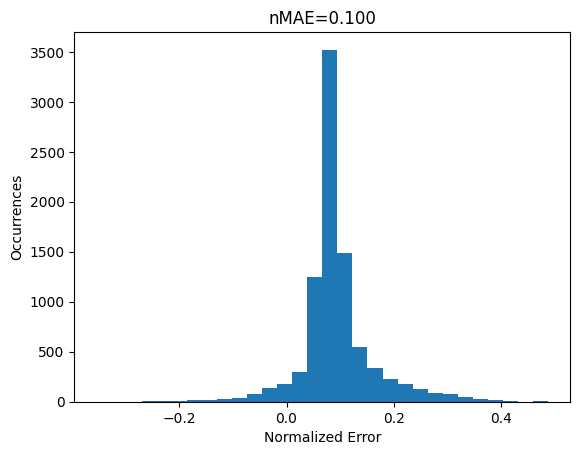

Persist-


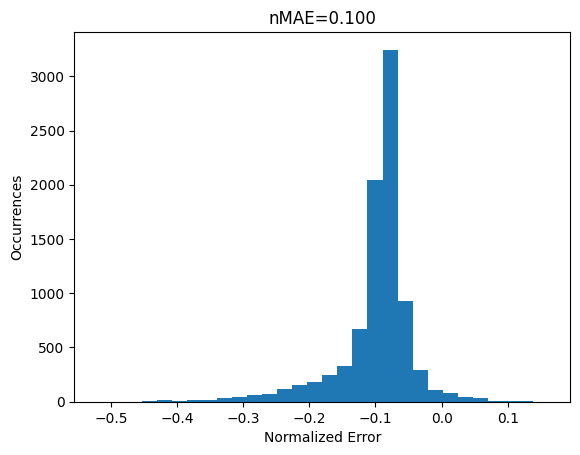

ConstantDn


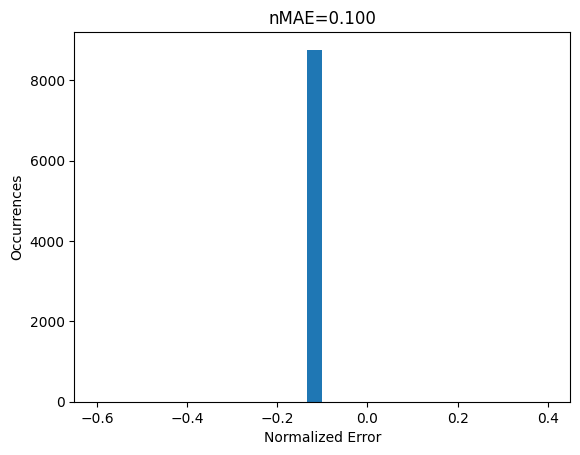

ConstantUp


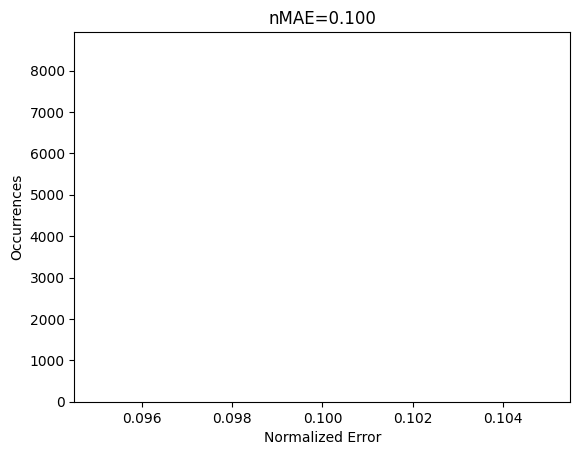

ScaleLinDn


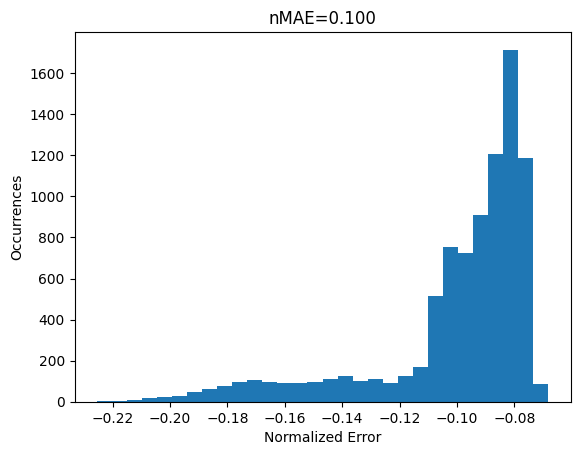

ScaleLinUp


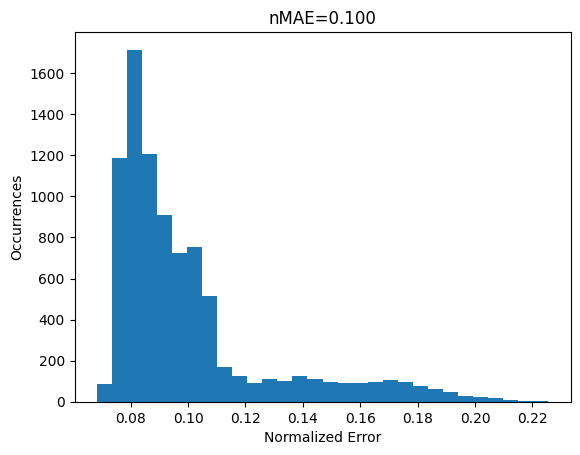

ScaleQuadDn


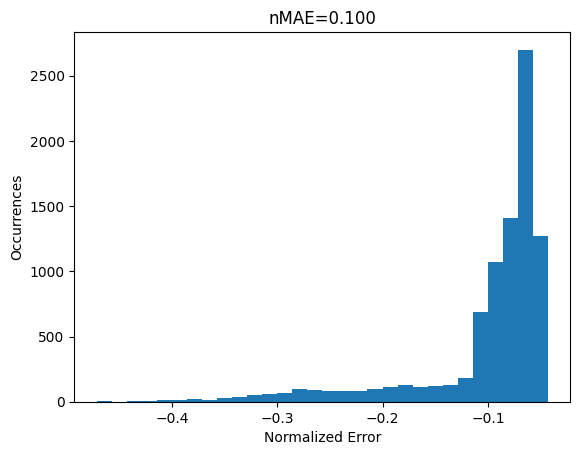

ScaleQuadUp


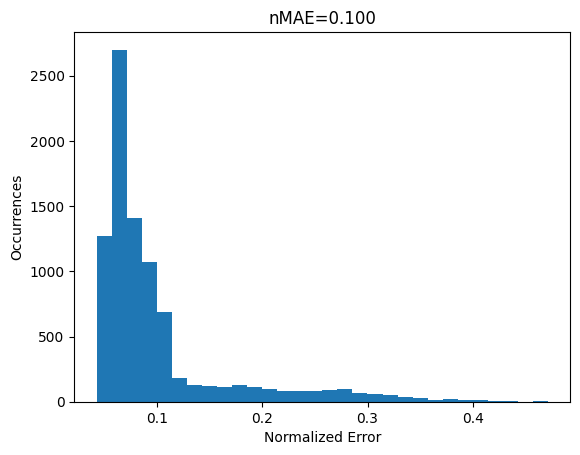

EnergyPricesDn


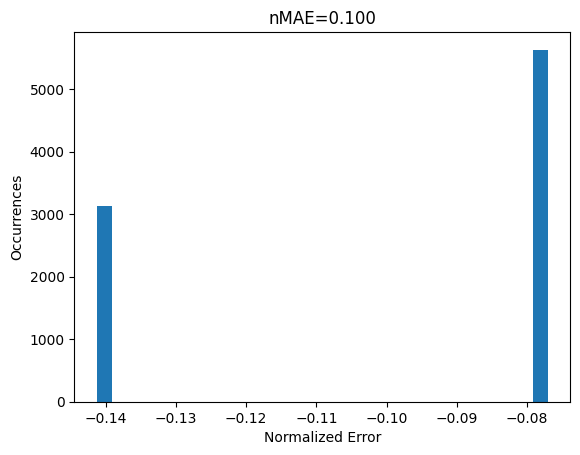

EnergyPricesUp


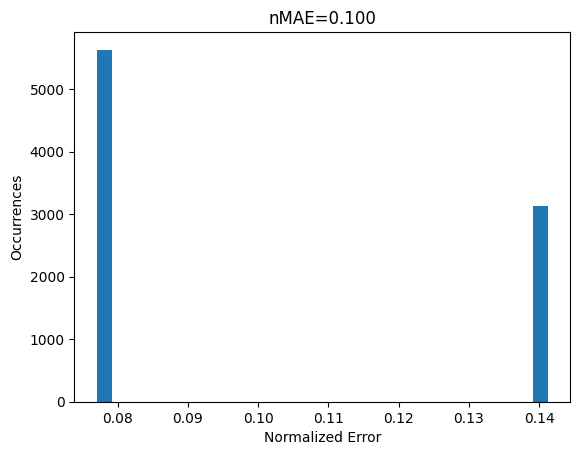

DemandPricesDn


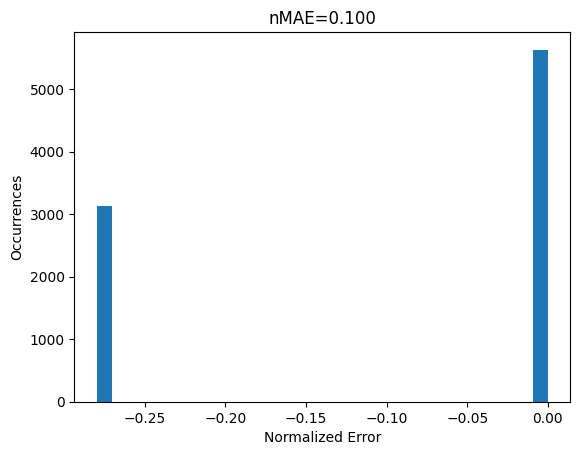

DemandPricesUp


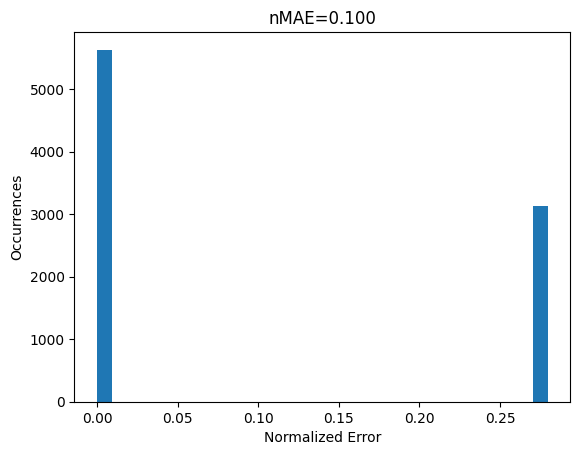

Random


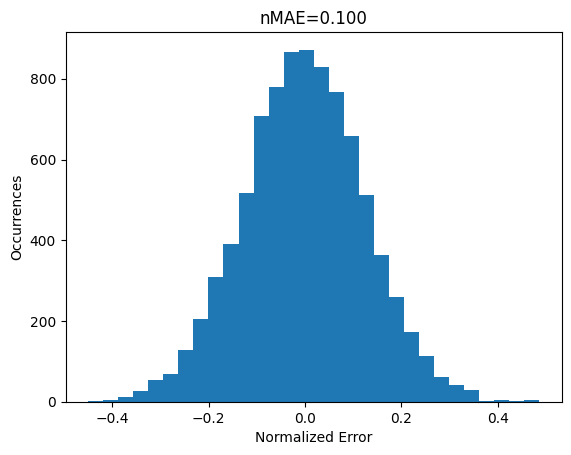

In [9]:
pd.options.plotting.backend='matplotlib'

for forecast in forecasts.columns.drop('Perfect'):
    e = (forecasts[forecast] - forecasts.Perfect)/forecasts.Perfect.max()
    ae = e.abs()
    
    print(forecast)
    plt.hist(e,bins=30)
    plt.title(f'nMAE={ae.mean():.3f}')
    plt.ylabel('Occurrences')
    plt.xlabel('Normalized Error')
    plt.show()



In [13]:
pd.options.plotting.backend='plotly'

e = []
sub_forecasts = ['Persist+','Persist-','ScaleLinDn','ScaleLinUp','ScaleQuadDn','ScaleQuadUp']
for forecast in sub_forecasts:
    e_new = (forecasts[forecast] - forecasts.Perfect)/forecasts.Perfect.max()
    e = e + list(e_new.values.flatten())

df = pd.DataFrame(np.array(e).reshape(-1,8760))
#df.index = ['Forecast 8','Forecast 3a','Forecast 3b','Forecast 4a','Forecast 4b']
f = df.T.hist(width=600,height=450)

f.update_layout(xaxis_title='Normalized Error',
                 yaxis_title='Occurrences',
                 title='Normalized Error Distribution',
                 barmode='overlay',
                 bargap=0.1,
                 bargroupgap=0.1,
                 template='plotly_white',
                 legend={'title':None})
#plt.hist(np.array(e).reshape(-1,8760).T,bins=30,alpha=0.5) ;
#plt.legend(sub_forecasts)
    


/home/mjw/miniconda3/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



# Perfect

In [14]:
post = create_post(cfg)

api_response = run_reopt(post,api_key=API_KEY,print_results=True)
dispatch_perfect = parse_dispatch_series(api_response)

costs_perfect = costs_from_api_response(api_response)
#costs_perfect = calc_retail_electric_cost(dispatch_perfect,tariff,cfg)

demand_costs_perfect = sum(calc_demand_charge2(dispatch_perfect,tariff,range(1,13)))

Trying API request: 1
Polling try 1
Polling try 2
Polling try 3
Success!
Status =  optimal
Energy cost ($) =  21867.31
Demand cost ($) =  4608.5
Fixed cost ($) =  0.0
Min charge adder ($) =  0.0
Energy revenue ($) =  8.0
Net cost ($) =  26467.81

PV Size (kW) =  130.0
Storage Size (kW-kwh) =  100.0 - 200.0


# Solar Only

In [15]:
post = create_post(cfg,batt_kw=0,batt_h=0)

api_response = run_reopt(post,api_key=API_KEY,print_results=True)
dispatch_solar = parse_dispatch_series(api_response)

costs_solar = costs_from_api_response(api_response)
#costs_solar = calc_retail_electric_cost(dispatch_solar,tariff,cfg)

Trying API request: 1
Polling try 1
Polling try 2
Polling try 3
Success!
Status =  optimal
Energy cost ($) =  24546.16
Demand cost ($) =  7951.44
Fixed cost ($) =  0.0
Min charge adder ($) =  0.0
Energy revenue ($) =  476.0
Net cost ($) =  32021.6

PV Size (kW) =  130.0


# Forecast

In [16]:
fcast1 = 'Random'
post = create_post(cfg,forecasts[fcast1])

api_response = run_reopt(post,api_key=API_KEY,print_results=True)
dispatch_forecast1 = parse_dispatch_series(api_response)

dispatch1 = dispatch_forecast1.copy()

dispatch1['load_forecast'] = dispatch1['load']
dispatch1['load'] = load[cfg.load_col]
dispatch1['grid'] = dispatch1.load - dispatch1.pv - dispatch1.batt

reopt_calc_retail_electric_cost(dispatch1,cfg)
#calc_retail_electric_cost(dispatch1,tariff,cfg)

Trying API request: 1
Polling try 1
Polling try 2
Polling try 3
Success!
Status =  optimal
Energy cost ($) =  21772.57
Demand cost ($) =  4847.39
Fixed cost ($) =  0.0
Min charge adder ($) =  0.0
Energy revenue ($) =  14.0
Net cost ($) =  26605.96

PV Size (kW) =  130.0
Storage Size (kW-kwh) =  100.0 - 200.0
Trying API request: 1
Polling try 1
Polling try 2
Polling try 3
Success!
Status =  optimal
Energy cost ($) =  22597.63
Demand cost ($) =  7396.14
Fixed cost ($) =  0.0
Min charge adder ($) =  0.0
Energy revenue ($) =  360.0
Net cost ($) =  29633.77

PV Size (kW) =  130.0


{'energy': 22597.63, 'demand': 7396.14, 'sellback': 360.0, 'total': 29633.77}

In [17]:
fcast2 = 'ConstantDn'
post = create_post(cfg,forecasts[fcast2])

api_response = run_reopt(post,api_key=API_KEY,print_results=True)
dispatch_forecast2 = parse_dispatch_series(api_response)

dispatch2 = dispatch_forecast2.copy()

dispatch2['load_forecast'] = dispatch2['load']
dispatch2['load'] = load[cfg.load_col]
dispatch2['grid'] = dispatch2.load - dispatch2.pv - dispatch2.batt

reopt_calc_retail_electric_cost(dispatch2,cfg)
#calc_retail_electric_cost(dispatch1,tariff,cfg)

Trying API request: 1
Polling try 1
Polling try 2
Polling try 3
Success!
Status =  optimal
Energy cost ($) =  14965.64
Demand cost ($) =  3317.12
Fixed cost ($) =  0.0
Min charge adder ($) =  0.0
Energy revenue ($) =  76.0
Net cost ($) =  18206.76

PV Size (kW) =  130.0
Storage Size (kW-kwh) =  100.0 - 200.0
Trying API request: 1
Polling try 1
Polling try 2
Polling try 3
Success!
Status =  optimal
Energy cost ($) =  22256.94
Demand cost ($) =  4608.56
Fixed cost ($) =  0.0
Min charge adder ($) =  0.0
Energy revenue ($) =  42.0
Net cost ($) =  26823.5

PV Size (kW) =  130.0


{'energy': 22256.94, 'demand': 4608.56, 'sellback': 42.0, 'total': 26823.5}

# Plot

## Actual

In [18]:
month = 8
peak_hours = list(range(9,21))

In [19]:
#fcast1 = '2b Constant-'

monthly_peaks = calc_monthly_peaks2(dispatch1.grid,peak_hours)
if monthly_peaks is not None:
    peak = monthly_peaks.iloc[month-1]['grid kw']
    t_peak = monthly_peaks.iloc[month-1]['grid t']
else:
    peak = None
    t_peak = None   

begin = t_peak - pd.Timedelta('1h')*36
end = t_peak + pd.Timedelta('1h')*36

f = plotly_stacked(dispatch1.loc[begin:end],
                    solar='pv',
                    load='load',
                    load_forecast='load_forecast',
                    batt='batt',
                    utility='grid',
                    soc='soc',
                    theme='plotly_white',
                    title=f'{fcast1} Forecast<br>Monthly Peak {peak} kW at {t_peak}')

In [20]:
#fcast2 = '7 Random'

monthly_peaks = calc_monthly_peaks2(dispatch2.grid,peak_hours)
if monthly_peaks is not None:
    peak2 = monthly_peaks.iloc[month-1]['grid kw']
    t_peak2 = monthly_peaks.iloc[month-1]['grid t']
else:
    peak2 = None
    t_peak2 = None   

begin2 = t_peak2 - pd.Timedelta('1h')*36
end2 = t_peak2 + pd.Timedelta('1h')*36

f = plotly_stacked(dispatch2.loc[begin:end],
                    solar='pv',
                    load='load',
                    load_forecast='load_forecast',
                    batt='batt',
                    utility='grid',
                    soc='soc',
                    theme='plotly_white',
                    title=f'{fcast2} Forecast<br>Monthly Peak {peak2} kW at {t_peak2}')

## Perfect

In [21]:
load_at_peak = dispatch_perfect.loc[t_peak,'grid']

f = plotly_stacked(dispatch_perfect.loc[begin:end],
                    solar='pv',
                    load='load',
                    load_forecast='load_forecast',
                    batt='batt',
                    utility='grid',
                    soc='soc',
                    theme='plotly_white',
                    title=f'Load {load_at_peak:.1f} kW at {t_peak}')

# Multiple Forecasts

Set up results df

In [22]:
# Ce cost of energy, Cd cost of demand, Re revenue of energy, Ct total cost
# p_x is performance based on Ce, Cd, Re, or Ct
# pk_x peak of month x, tpk_x time of peak of month x
cols = ['Ce','Cd','Re','Ct','p_Ce','p_Cd','p_Re','p_Ct']
cols = cols + [f'pk_{m}' for m in range(1,13)] + [f'tpk_{m}' for m in range(1,13)]
cols = cols + ['dispatch']
r = pd.DataFrame(columns=cols,index=forecasts.columns)

Insert perfect results

In [23]:
peaks = calc_monthly_peaks2(dispatch_perfect.grid,peak_hours)['grid kw'].values
t_peaks = calc_monthly_peaks2(dispatch_perfect.grid,peak_hours)['grid t'].values

r.loc['Perfect'] = {'Ce':costs_perfect.energy,'Cd':costs_perfect.demand,'Re':costs_perfect.sellback,'Ct':costs_perfect.total,
                    'p_Ce':1,'p_Cd':1,'p_Re':1,'p_Ct':1,
                    'pk_1':peaks[0],'pk_2':peaks[1],'pk_3':peaks[2],'pk_4':peaks[3],'pk_5':peaks[4],'pk_6':peaks[5],'pk_7':peaks[6],'pk_8':peaks[7],'pk_9':peaks[8],'pk_10':peaks[9],'pk_11':peaks[10],'pk_12':peaks[11],
                    'tpk_1':t_peaks[0],'tpk_2':t_peaks[1],'tpk_3':t_peaks[2],'tpk_4':t_peaks[3],'tpk_5':t_peaks[4],'tpk_6':t_peaks[5],'tpk_7':t_peaks[6],'tpk_8':t_peaks[7],'tpk_9':t_peaks[8],'tpk_10':t_peaks[9],'tpk_11':t_peaks[10],'tpk_12':t_peaks[11],
                    'dispatch':dispatch_perfect}

Insert solar-only results

In [24]:
peaks =   calc_monthly_peaks2(dispatch_solar.grid,peak_hours)['grid kw'].values
t_peaks = calc_monthly_peaks2(dispatch_solar.grid,peak_hours)['grid t'].values

r.loc['SolarOnly'] = {'Ce':costs_solar.energy,'Cd':costs_solar.demand,'Re':costs_solar.sellback,'Ct':costs_solar.total,
                    'p_Ce':0,'p_Cd':0,'p_Re':0,'p_Ct':0,
                    'pk_1':peaks[0],'pk_2':peaks[1],'pk_3':peaks[2],'pk_4':peaks[3],'pk_5':peaks[4],'pk_6':peaks[5],'pk_7':peaks[6],'pk_8':peaks[7],'pk_9':peaks[8],'pk_10':peaks[9],'pk_11':peaks[10],'pk_12':peaks[11],
                    'tpk_1':t_peaks[0],'tpk_2':t_peaks[1],'tpk_3':t_peaks[2],'tpk_4':t_peaks[3],'tpk_5':t_peaks[4],'tpk_6':t_peaks[5],'tpk_7':t_peaks[6],'tpk_8':t_peaks[7],'tpk_9':t_peaks[8],'tpk_10':t_peaks[9],'tpk_11':t_peaks[10],'tpk_12':t_peaks[11],
                    'dispatch':dispatch_solar}

In [25]:
for fcast in forecasts.columns[1:]:    
    print('///// ',fcast,' /////')
    post = create_post(cfg,forecasts[fcast])
    try:
        api_response = run_reopt(post,api_key=API_KEY,print_results=True)
        d = parse_dispatch_series(api_response)
        #d = d.copy()
        
        # make the dispatch actual
        d['load_forecast'] = d['load']
        d['load'] = load[cfg.load_col]
        d['grid'] = d.load - d.pv - d.batt

        c = reopt_calc_retail_electric_cost(d,cfg)
        
        pks =   calc_monthly_peaks2(d.grid,peak_hours)['grid kw'].values
        tpks = calc_monthly_peaks2(d.grid,peak_hours)['grid t'].values
        
        p_Ce=round(1 - (c.energy-costs_perfect.energy)/(costs_solar.energy-costs_perfect.energy),3)
        if (costs_solar.demand-costs_perfect.demand) != 0:
            p_Cd=round(1 - (c.demand-costs_perfect.demand)/(costs_solar.demand-costs_perfect.demand),3)
        else:
            p_Cd=nan
        p_Re=round(1 - (c.sellback-costs_perfect.sellback)/(costs_solar.sellback-costs_perfect.sellback),3)
        p_Ct=round(1 - (c.total-costs_perfect.total)/(costs_solar.total-costs_perfect.total),3)
        
        
        r.loc[fcast] = {'Ce':c.energy,'Cd':c.demand,'Re':c.sellback,'Ct':c.total,
                        'p_Ce':p_Ce,'p_Cd':p_Cd,'p_Re':p_Re,'p_Ct':p_Ct,
                        'pk_1':pks[0],'pk_2':pks[1],'pk_3':pks[2],'pk_4':pks[3],'pk_5':pks[4],'pk_6':pks[5],'pk_7':pks[6],'pk_8':pks[7],'pk_9':pks[8],'pk_10':pks[9],'pk_11':pks[10],'pk_12':pks[11],
                        'tpk_1':tpks[0],'tpk_2':tpks[1],'tpk_3':tpks[2],'tpk_4':tpks[3],'tpk_5':tpks[4],'tpk_6':tpks[5],'tpk_7':tpks[6],'tpk_8':tpks[7],'tpk_9':tpks[8],'tpk_10':tpks[9],'tpk_11':tpks[10],'tpk_12':tpks[11],
                        'dispatch':d}
    except:
        print('API Request fully failed')
    

/////  Persist+  /////
Trying API request: 1
Polling try 1
Polling try 2
Polling try 3
Success!
Status =  optimal
Energy cost ($) =  28923.54
Demand cost ($) =  6076.56
Fixed cost ($) =  0.0
Min charge adder ($) =  0.0
Energy revenue ($) =  0.0
Net cost ($) =  35000.1

PV Size (kW) =  130.0
Storage Size (kW-kwh) =  100.0 - 200.0
Trying API request: 1
Polling try 1
Polling try 2
Trying API request: 2
Polling try 1
Polling try 2


In [ ]:
# forecasts_clean = ['1 Perfect', '8 Persist', '2b Constant-', '2a Constant+', '3b Linear-',
#        '3a Linear+', '4b Quad-', '4a Quad+', '5b Energy-',
#        '5a Energy+', '6b Demand-', '6a Demand+', '7 Random',
#        '9 Solar']

# r.index = forecasts_clean

In [ ]:
r[['Ce','Cd','Re','Ct']].sort_values('Ct')

,Ce,Cd,Re,Ct
Perfect,21867.31,4608.50,8.00,26467.81
ConstantDn,22256.94,4608.56,42.00,26823.50
ConstantUp,22805.10,4608.56,574.00,26839.66
EnergyPricesUp,22959.75,4608.56,639.00,26929.31
EnergyPricesDn,22449.53,4608.56,39.00,27019.09
ScaleLinDn,22293.84,4851.25,36.00,27109.09
DemandPricesUp,23256.18,4608.56,725.00,27139.74
ScaleLinUp,22786.99,4984.94,561.00,27210.93
ScaleQuadUp,22742.46,5425.37,530.00,27637.83
ScaleQuadDn,22433.59,5340.66,29.00,27745.25


In [ ]:
r[['p_Ce','p_Cd','p_Re','p_Ct']].sort_values('p_Ct')

,p_Ce,p_Cd,p_Re,p_Ct
Persist-,-0.00,-0.00,0.00,-0.00
SolarOnly,0,0,0,0
Persist+,-0.14,0.02,-2.44,0.15
Random,0.72,0.22,0.25,0.46
DemandPricesDn,0.38,0.99,0.94,0.70
ScaleQuadDn,0.79,0.78,0.95,0.77
ScaleQuadUp,0.67,0.76,-0.12,0.79
ScaleLinUp,0.66,0.89,-0.18,0.87
DemandPricesUp,0.48,1.00,-0.53,0.88
ScaleLinDn,0.84,0.93,0.94,0.89


In [ ]:
r[['p_Ce','p_Cd','p_Re','p_Ct']].corr()['p_Ct']

p_Ce   0.87
p_Cd   0.97
p_Re   0.45
p_Ct   1.00
Name: p_Ct, dtype: float64

In [ ]:
f = r[['p_Ct','p_Cd','p_Ce','p_Re']].sort_values('p_Ct').plot(width=600,height=450)

f.update_layout(yaxis_title='Performance',
                     xaxis_title='Forecast',
                     title='Performance of Forecasts',
                     template='plotly_white',
                     legend={'title':None})



In [ ]:
r.sort_values('p_Ct')[[f'pk_{i}' for i in range(1,13)]].T

,Persist-,SolarOnly,Persist+,Random,DemandPricesDn,ScaleQuadDn,ScaleQuadUp,ScaleLinUp,DemandPricesUp,ScaleLinDn,EnergyPricesDn,EnergyPricesUp,ConstantUp,ConstantDn,Perfect
pk_1,51.70,51.00,51.00,53.10,42.80,42.80,42.80,42.80,42.80,42.80,42.80,42.80,42.80,42.80,42.80
pk_2,51.50,51.50,51.20,56.00,44.50,44.50,44.50,44.50,44.50,44.50,44.50,44.50,44.50,44.50,44.50
pk_3,52.30,52.30,51.70,48.20,42.40,42.40,42.40,42.40,42.40,42.40,42.40,42.40,42.40,42.40,42.40
pk_4,48.60,48.60,44.10,42.20,38.50,38.50,38.50,38.50,38.50,38.50,38.50,38.50,38.50,38.50,38.50
pk_5,67.80,67.80,67.80,53.40,45.30,45.30,45.30,45.30,45.30,45.30,45.30,45.30,45.30,45.30,45.30
pk_6,88.30,88.30,88.30,73.60,60.50,60.50,60.50,60.50,60.50,60.50,60.50,60.50,60.50,60.50,60.50
pk_7,88.70,88.70,88.70,75.30,60.50,61.60,60.50,60.50,60.50,60.50,60.50,60.50,60.50,60.50,60.50
pk_8,87.70,87.70,87.70,68.60,52.50,60.30,63.70,54.60,52.50,52.50,52.50,52.50,52.50,52.50,52.50
pk_9,81.90,81.90,81.90,81.90,56.60,70.20,69.00,61.80,56.60,59.40,56.60,56.60,56.60,56.60,56.60
pk_10,72.10,72.10,72.10,65.60,47.90,52.80,54.60,48.60,47.90,47.90,47.90,47.90,47.90,47.90,47.90


In [ ]:
r_peakplot = r.sort_values('p_Ct')[[f'pk_{i}' for i in range(1,13)]].T
r_peakplot.index = list(range(1,13))
f = r_peakplot.plot(width=600,height=450)

f.update_layout(yaxis_title='Peak Load [kW]',
                     xaxis_title='Month',
                     title='Monthly Peaks',
                     template='plotly_white',
                     legend={'title':None})

In [ ]:
r.drop('dispatch',axis=1).to_csv(cfg.outdir+'results.csv')

In [ ]:
for fcast,df in zip(r.index,r.dispatch):
    df.to_csv(cfg.outdir+f'dispatch_{fcast}.csv')

In [ ]:
cfg

{'version': 30,
 'note': None,
 'dev': False,
 'test': False,
 'data_dir': 'data/',
 'out_dir': 'outputs/',
 'interval': '1h',
 'load_file': 'data/load/Jail_load_solar_1min_2021-4-21_2022-4-19_profilized.csv',
 'load_col': 'Load [kW]',
 'load_persist_col': 'Load Persist 7d [kW]',
 'load_forecast_file': 'data/load/Jail_load_solar_1min_2021-4-21_2022-4-19_profilized_fake_forecast.csv',
 'load_forecast_col': 'Persist7d',
 'solar_file': 'data/load/Jail_load_solar_1min_2021-4-21_2022-4-19_profilized.csv',
 'solar_col': 'Solar [kW]',
 'solar_capacity_kw': 130,
 'solar_kw': 130,
 'batt_kw': 100,
 'batt_h': 2,
 'tariff_file': 'data/tariff/bayfield.json',
 'energy_price_sell_constant': 0.05,
 'post': {'Settings': {'time_steps_per_hour': 1},
  'Site': {'longitude': 45.50589, 'latitude': 9.16099},
  'PV': {'array_type': 0,
   'can_net_meter': False,
   'min_kw': 130,
   'max_kw': 130,
   'production_factor_series': [0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    